# 3. Simplify

The model in section 1 does not seem very interesting, attempt to use the following nodes to improve the model:

Nodes:

Links:



https://pgmpy.org/detailed_notebooks/11.%20A%20Bayesian%20Network%20to%20model%20the%20influence%20of%20energy%20consumption%20on%20greenhouse%20gases%20in%20Italy.html?highlight=weighted


https://pgmpy.org/detailed_notebooks/10.%20Learning%20Bayesian%20Networks%20from%20Data.html?highlight=equivalent_sample_size

In [1]:
import pandas as pd

from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.estimators import ParameterEstimator
from pgmpy.factors.discrete import TabularCPD, DiscreteFactor
from pgmpy.inference import VariableElimination
from pgmpy.models import BayesianNetwork

from sklearn.metrics import classification_report, confusion_matrix


## 1.1 Data Preparation & Cleaning

### 1.1.1 Load Source Date

In [2]:
# load the source data
df_source = pd.read_csv('data/raw/DataCoSupplyChainDataset.csv', encoding='unicode_escape')
df_source.drop_duplicates(inplace=True)

print(df_source.shape)
with pd.option_context('display.max_columns', None):
    display(df_source.head())

(180519, 53)


,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,order date (DateOrders),Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,20755,1/31/2018 22:56,77202,1360,13.110000,0.04,180517,327.75,0.29,1,327.75,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,19492,1/13/2018 12:27,75939,1360,16.389999,0.05,179254,327.75,-0.80,1,327.75,311.359985,-249.089996,South Asia,Rajastán,PENDING,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,19491,1/13/2018 12:06,75938,1360,18.030001,0.06,179253,327.75,-0.80,1,327.75,309.720001,-247.779999,South Asia,Rajastán,CLOSED,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,EE. UU.,XXXXXXXXX,Tana,19490,Tate,XXXXXXXXX,Home Office,CA,3200 Amber Bend,90027.0,2,Fitness,34.125946,-118.291016,Pacific Asia,Townsville,Australia,19490,1/13/2018 11:45,75937,1360,22.940001,0.07,179252,327.75,0.08,1,327.75,304.809998,22.860001,Oceania,Queensland,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Orli,19489,Hendricks,XXXXXXXXX,Corporate,PR,8671 Iron Anchor Corners,725.0,2,Fitness,18.253769,-66.037048,Pacific Asia,Townsville,Australia,19489,1/13/2018 11:24,75936,1360,29.500000,0.09,179251,327.75,0.45,1,327.75,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


## 1.2 Data Visualization & Analysis

<AxesSubplot: >

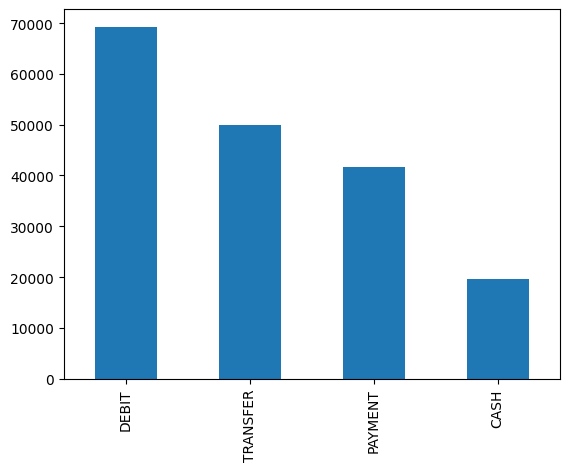

In [3]:
# payment type
df_source['Type'].value_counts().plot(kind='bar')

<AxesSubplot: >

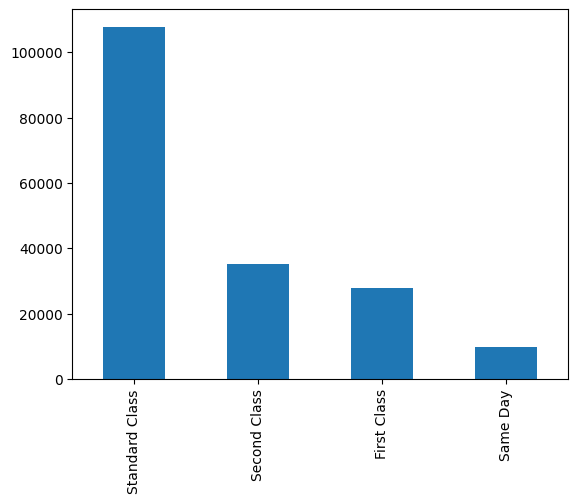

In [4]:
# shipping mode
df_source['Shipping Mode'].value_counts().plot(kind='bar')

<AxesSubplot: >

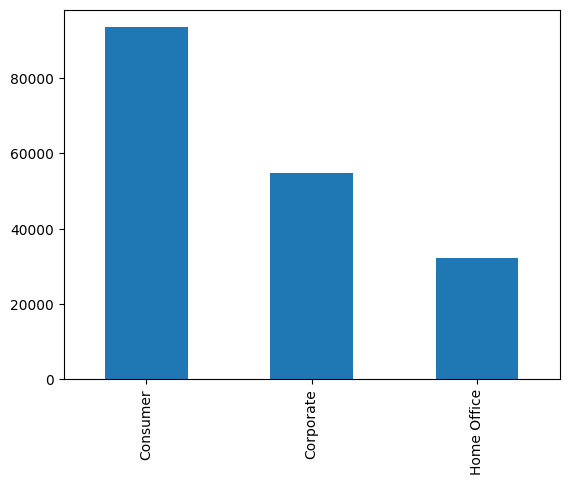

In [5]:
# customer segment
df_source['Customer Segment'].value_counts().plot(kind='bar')

<AxesSubplot: >

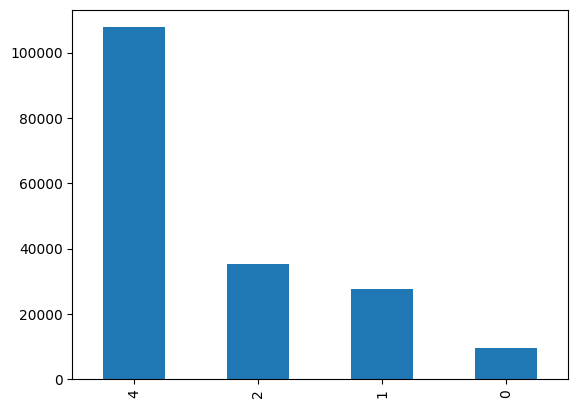

In [6]:
# Days for shipment (scheduled)
df_source['Days for shipment (scheduled)'].value_counts().plot(kind='bar')

<AxesSubplot: >

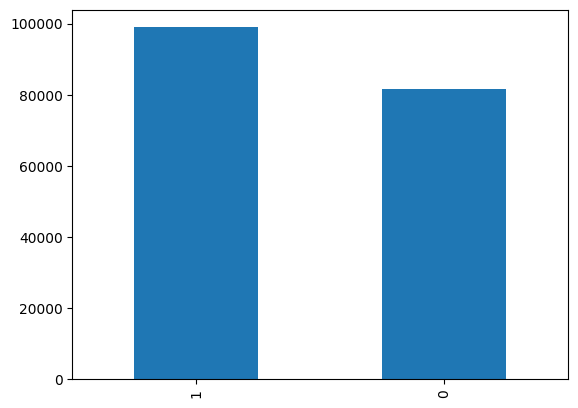

In [7]:
# Late_delivery_risk
df_source['Late_delivery_risk'].value_counts().plot(kind='bar')

In [8]:
# Customer State
customer_state_vc = df_source['Customer State'].value_counts()

print(f'Number of states: {len(customer_state_vc)}')
print(customer_state_vc)

Number of states: 46
PR       69373
CA       29223
NY       11327
TX        9103
IL        7631
FL        5456
OH        4095
PA        3824
MI        3804
NJ        3191
AZ        3026
GA        2503
MD        2415
NC        1992
CO        1914
VA        1849
OR        1668
MA        1607
TN        1582
NV        1440
MO        1354
HI        1248
CT        1094
UT         968
NM         949
LA         948
WA         920
WI         850
MN         672
SC         665
IN         581
DC         579
KY         487
KS         458
DE         269
RI         243
WV         241
OK         232
ND         215
ID         167
AR         164
MT          87
IA          67
AL          35
95758        2
91732        1
Name: Customer State, dtype: int64


<AxesSubplot: >

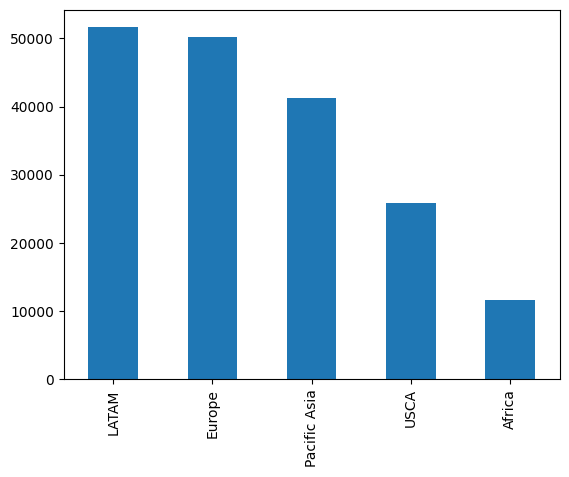

In [9]:
# market
df_source['Market'].value_counts().plot(kind='bar')

> - A question could be which store is most likely to have a late delivery risk?
> - which store does not deliver to the market

In [10]:
# State to which the store where the purchase is registered belongs
df_source[df_source['Market'] == 'Africa']['Customer State'].value_counts()

PR    4198
CA    1812
NY     753
TX     657
IL     500
FL     379
PA     310
OH     275
MI     207
GA     202
AZ     198
NJ     196
CO     152
OR     145
MD     139
VA     136
NC     115
MO     112
MA     106
HI      92
NM      89
TN      87
NV      69
WI      68
LA      67
IN      67
WA      65
SC      55
MN      54
CT      43
DC      43
UT      42
KY      27
WV      27
KS      24
DE      24
AR      17
ND      17
RI      15
AL      10
OK      10
ID       5
IA       3
MT       2
Name: Customer State, dtype: int64

In [11]:
# customer city
customer_city_vc = df_source['Customer City'].value_counts()
customer_city_vc

Caguas         66770
Chicago         3885
Los Angeles     3417
Brooklyn        3412
New York        1816
               ...  
Bartlett          25
Malden            22
Ponce             22
Freehold          13
CA                 3
Name: Customer City, Length: 563, dtype: int64

<AxesSubplot: >

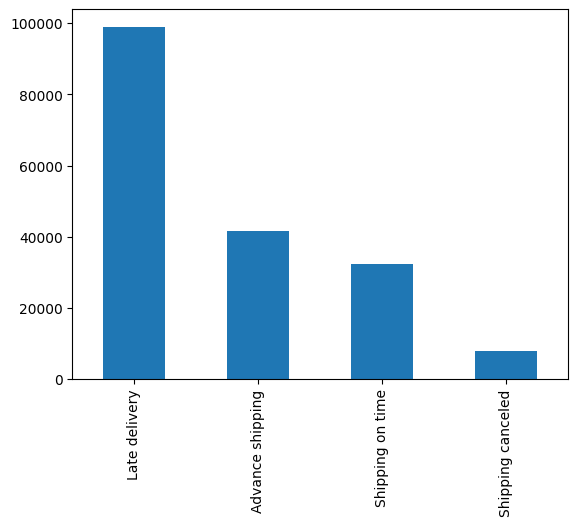

In [12]:
# delivery status
df_source['Delivery Status'].value_counts().plot(kind='bar')

## 1.3 Feature Engineering

Select the columns that will be used as the network nodes and remove duplicate records to have a single record per order.

In [13]:
nodes = [
    'Order Id',
    'Shipping Mode',
    'Customer Segment',
    'Days for shipment (scheduled)',
    'Delivery Status',
    'Customer State',
    'Market',
]

df_data = df_source[nodes] \
    .rename(columns={
        'Type': 'Payment Type',
        'Customer State': 'Store State'}) \
    .drop_duplicates() \
    .reset_index(drop=True)


print(df_data.shape)
with pd.option_context('display.max_columns', None):
    display(df_data.head())

(65752, 7)


,Order Id,Shipping Mode,Customer Segment,Days for shipment (scheduled),Delivery Status,Store State,Market
0,77202,Standard Class,Consumer,4,Advance shipping,PR,Pacific Asia
1,75939,Standard Class,Consumer,4,Late delivery,PR,Pacific Asia
2,75938,Standard Class,Consumer,4,Shipping on time,CA,Pacific Asia
3,75937,Standard Class,Home Office,4,Advance shipping,CA,Pacific Asia
4,75936,Standard Class,Corporate,4,Advance shipping,PR,Pacific Asia


In [14]:
# find columns with missing values
df_data.isnull().sum()

Order Id                         0
Shipping Mode                    0
Customer Segment                 0
Days for shipment (scheduled)    0
Delivery Status                  0
Store State                      0
Market                           0
dtype: int64

### 1.3.1 Create a Training and Test Set

In [15]:
random_state = 98421

In [16]:
# create the training dataset
df_test = df_data.sample(frac=0.3, random_state=random_state)
df_train = df_data.drop(df_test.index)

# reset the index of both datasets
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

print(f'Training dataset shape : {df_train.shape}')
print(f'Test dataset shape     : {df_test.shape}')

Training dataset shape : (46026, 7)
Test dataset shape     : (19726, 7)


## 1.4 Model Training

### 1.4.1 Model Definition

Define the model nodes and edges.

In [17]:
# Create the Bayesian network model
model = BayesianNetwork()

# Add the nodes to the model
model.add_node('Shipping Mode')
model.add_node('Customer Segment')
model.add_node('Days for shipment (scheduled)')
model.add_node('Delivery Status')
model.add_node('Store State')
model.add_node('Market')


# Add the edges between the nodes to the model
model.add_edge('Delivery Status', 'Shipping Mode')
model.add_edge('Delivery Status', 'Customer Segment')
model.add_edge('Delivery Status', 'Days for shipment (scheduled)')
model.add_edge('Delivery Status', 'Store State')
model.add_edge('Delivery Status', 'Market')


### 1.4.2 Compute the Probability Distribution Table (PDT)

In [18]:
pe = ParameterEstimator(model, df_train)
pe.state_counts('Shipping Mode')
#pe.state_counts('Delivery Status')

Delivery Status,Advance shipping,Late delivery,Shipping canceled,Shipping on time
Shipping Mode,,,,
First Class,0.0,6719.0,313.0,0.0
Same Day,0.0,1110.0,119.0,1220.0
Second Class,0.0,6899.0,369.0,1725.0
Standard Class,10566.0,10479.0,1223.0,5284.0


In [19]:
est = BayesianEstimator(model, df_train)

print(est.estimate_cpd('Customer Segment', prior_type='BDeu', equivalent_sample_size=10))

+-------------------------------+-----+
| Delivery Status               | ... |
+-------------------------------+-----+
| Customer Segment(Consumer)    | ... |
+-------------------------------+-----+
| Customer Segment(Corporate)   | ... |
+-------------------------------+-----+
| Customer Segment(Home Office) | ... |
+-------------------------------+-----+


In [20]:
# # Create a MaximumLikelihoodEstimator object
# estimator = MaximumLikelihoodEstimator(model, df_train)

# estimator.get_parameters(weighted=True)

In [21]:
model.fit(
    data=df_train, 
    estimator=BayesianEstimator,
    prior_type='BDeu',
    equivalent_sample_size=10)

In [22]:
# model.fit(
#     data=df_train, 
#     estimator=MaximumLikelihoodEstimator)

In [23]:
# Check if the model is valid
model.check_model()

True

In [24]:
model_cpds = model.get_cpds()
model_cpds

[<TabularCPD representing P(Shipping Mode:4 | Delivery Status:4) at 0x7fc076014670>,
 <TabularCPD representing P(Customer Segment:3 | Delivery Status:4) at 0x7fc075ffee20>,
 <TabularCPD representing P(Days for shipment (scheduled):4 | Delivery Status:4) at 0x7fc076014520>,
 <TabularCPD representing P(Delivery Status:4) at 0x7fc0760149a0>,
 <TabularCPD representing P(Store State:46 | Delivery Status:4) at 0x7fc076479370>,
 <TabularCPD representing P(Market:5 | Delivery Status:4) at 0x7fc0760147c0>]

In [25]:
for cpd in model_cpds:
    print(f'--- {cpd.variable} ---')
    print(cpd.values, end='\n\n')

--- Shipping Mode ---
[[5.91380044e-05 2.66551300e-01 1.54761905e-01 7.59278382e-05]
 [5.91380044e-05 4.40558123e-02 5.90303479e-02 1.48287068e-01]
 [5.91380044e-05 2.73691466e-01 1.82395756e-01 2.09636761e-01]
 [9.99822586e-01 4.15701422e-01 6.03811991e-01 6.42000243e-01]]

--- Customer Segment ---
[[0.5214395  0.52055111 0.5254544  0.52017656]
 [0.3031493  0.29928532 0.28957974 0.29956063]
 [0.17541121 0.18016356 0.18496587 0.18026281]]

--- Days for shipment (scheduled) ---
[[5.91380044e-05 4.40558123e-02 5.90303479e-02 1.48287068e-01]
 [5.91380044e-05 2.66551300e-01 1.54761905e-01 7.59278382e-05]
 [5.91380044e-05 2.73691466e-01 1.82395756e-01 2.09636761e-01]
 [9.99822586e-01 4.15701422e-01 6.03811991e-01 6.42000243e-01]]

--- Delivery Status ---
[0.22957034 0.54760405 0.0440199  0.17880572]

--- Store State ---
[[5.14243517e-06 2.15584705e-06 2.68185670e-05 1.28086962e-04]
 [5.14243517e-06 2.15584705e-06 2.68185670e-05 1.28086962e-04]
 [1.94384049e-04 2.00493775e-04 2.68185670e-05 

## 1.5 Model Details

In [26]:
model.active_trail_nodes('Delivery Status')

{'Delivery Status': {'Customer Segment',
  'Days for shipment (scheduled)',
  'Delivery Status',
  'Market',
  'Shipping Mode',
  'Store State'}}

In [27]:
model.get_independencies()

(Shipping Mode ⟂ Days for shipment (scheduled), Market, Store State, Customer Segment | Delivery Status)
(Shipping Mode ⟂ Days for shipment (scheduled), Market, Customer Segment | Store State, Delivery Status)
(Shipping Mode ⟂ Days for shipment (scheduled), Store State, Customer Segment | Market, Delivery Status)
(Shipping Mode ⟂ Market, Store State, Customer Segment | Days for shipment (scheduled), Delivery Status)
(Shipping Mode ⟂ Days for shipment (scheduled), Market, Store State | Delivery Status, Customer Segment)
(Shipping Mode ⟂ Days for shipment (scheduled), Customer Segment | Market, Store State, Delivery Status)
(Shipping Mode ⟂ Market, Customer Segment | Days for shipment (scheduled), Store State, Delivery Status)
(Shipping Mode ⟂ Days for shipment (scheduled), Market | Store State, Delivery Status, Customer Segment)
(Shipping Mode ⟂ Store State, Customer Segment | Days for shipment (scheduled), Market, Delivery Status)
(Shipping Mode ⟂ Days for shipment (scheduled), Store S

## 1.6 Model Queries

In [28]:
infer = VariableElimination(model)

In [29]:
def get_ratios(probabilities: DiscreteFactor, col_name: str='Ratio') -> pd.DataFrame:
    """
    Show probabilities for a given variable.

    Parameters
    ----------
    probabilities : DiscreteFactor
        Probabilities for the variable.

    Returns
    -------
    pd.DataFrame
        Probabilities for the variable.
    """
    # Get the probabilities for each value
    value_probabilities = probabilities.values
    variable_name = list(probabilities.state_names.keys())[0]
    state_names = probabilities.state_names[variable_name]

    # create a dataframe with the probabilities
    return pd.DataFrame(
        data=value_probabilities,
        index=state_names,
        columns=[col_name]) \
        .sort_values(by=col_name, ascending=False)

### 1.6.1 What is the probability of a late delivery?

In [30]:
late_delivery = infer.query(
    variables=['Delivery Status'],
    joint=False)

print(late_delivery['Delivery Status'])

+------------------------------------+------------------------+
| Delivery Status                    |   phi(Delivery Status) |
+====================================+========================+
| Delivery Status(Advance shipping)  |                 0.2296 |
+------------------------------------+------------------------+
| Delivery Status(Late delivery)     |                 0.5476 |
+------------------------------------+------------------------+
| Delivery Status(Shipping canceled) |                 0.0440 |
+------------------------------------+------------------------+
| Delivery Status(Shipping on time)  |                 0.1788 |
+------------------------------------+------------------------+


### 1.6.2 Which states handle the most late deliveries?

We can see that this is close the the same ratio as the total number of orders per state, given that we know that 54.7% of the orders are late.

In [31]:
# Query the probability of a late delivery for each state
state_late_delivery = infer.query(
    variables=['Store State'],
    evidence={'Delivery Status': 'Late delivery'})

get_ratios(state_late_delivery).head(5)

,Ratio
PR,0.384460
CA,0.163790
NY,0.061289
TX,0.051451
IL,0.042407


In [32]:
df_train['Store State'].value_counts(normalize=True).head(5)

PR    0.384457
CA    0.161908
NY    0.063138
TX    0.050841
IL    0.041259
Name: Store State, dtype: float64

#### 1.6.2.1 What is the probability of a late delivery per store?

In [33]:
df_store_late_delivery = pd.DataFrame()

for state_name in list(state_late_delivery.state_names.values())[0]:
    # get the delivery status probabilities for the state
    df_state = get_ratios(
        infer.query(
            variables=['Delivery Status'],
            evidence={'Store State': state_name})
    )

    # add the state name to the dataframe
    df_state['Store State'] = state_name

    # append the dataframe to the main dataframe    
    df_store_late_delivery = df_store_late_delivery.append(df_state \
        .reset_index(drop=False) \
        .rename(columns={'index': 'Delivery Status'})
    )

# show the stores with the highest probability of late delivery
df_store_late_delivery \
    .query('`Delivery Status` == "Late delivery"') \
    .drop(columns=['Delivery Status']) \
    .reindex(columns=['Store State', 'Ratio']) \
    .sort_values(by='Ratio', ascending=False) \
    .reset_index(drop=True) \
    .head(5)

,Store State,Ratio
0,DE,0.636464
1,IA,0.605337
2,NM,0.602145
3,WA,0.593830
4,MN,0.580801


> We have discovered that the [state](https://www.scouting.org/resources/los/states/) Delaware (DE) has the highest probability of late delivery as reflected in the data below. This is an example that warrents further investigation.

In [34]:
df_train[df_train['Store State'] == 'DE']

,Order Id,Shipping Mode,Customer Segment,Days for shipment (scheduled),Delivery Status,Store State,Market
28,75901,Same Day,Consumer,0,Shipping canceled,DE,Pacific Asia
657,20755,Standard Class,Corporate,4,Late delivery,DE,Pacific Asia
698,75778,Second Class,Home Office,2,Late delivery,DE,Pacific Asia
760,73184,Standard Class,Consumer,4,Late delivery,DE,Pacific Asia
2329,74199,Standard Class,Corporate,4,Late delivery,DE,Pacific Asia
...,...,...,...,...,...,...,...
41631,40463,Second Class,Home Office,2,Late delivery,DE,USCA
44113,3903,Standard Class,Home Office,4,Shipping on time,DE,LATAM
44565,38525,Second Class,Home Office,2,Late delivery,DE,USCA
44651,70330,Standard Class,Home Office,4,Late delivery,DE,Europe


### 1.6.3 Which Market has the most late deliveries?

In [35]:
# Which Market is most likely to have a late delivery?
market_late_delivery = infer.query(
    variables=['Market'],
    evidence={'Delivery Status': 'Late delivery'})

get_ratios(market_late_delivery).head(5)


,Ratio
Europe,0.285150
Pacific Asia,0.268926
LATAM,0.257899
USCA,0.130090
Africa,0.057935


#### 1.6.3.1 What is the probability of a late delivery in Europe?

In [36]:
get_ratios(
    infer.query(
        variables=['Delivery Status'],
        evidence={'Market': 'Europe'}),
    col_name='Probability')

,Probability
Late delivery,0.553643
Advance shipping,0.230553
Shipping on time,0.173791
Shipping canceled,0.042013


#### 1.6.3.2 Which shipping method has the most late deliveries in the Pacific Asia Market?

In [37]:
shipping_mode_late_delivery = infer.query(
    variables=['Shipping Mode'],
    evidence={
        'Delivery Status': 'Late delivery',
        'Market': 'Pacific Asia'
    })

get_ratios(shipping_mode_late_delivery).head(5)

,Ratio
Standard Class,0.415701
Second Class,0.273691
First Class,0.266551
Same Day,0.044056


#### 1.6.3.3 What is the probability of a late delivery for orders in the Pacific Asia Market sipped using Standard Class?

In [38]:
get_ratios(
    infer.query(
        variables=['Delivery Status'],
        evidence={
            'Shipping Mode': 'Standard Class',
            'Market': 'Pacific Asia'
        }),
    col_name='Probability'
).loc['Late delivery']

Probability    0.380781
Name: Late delivery, dtype: float64

### 1.6.4 Which customer segment has the most late deliveries?

In [39]:
get_ratios(
    infer.query(
        variables=['Customer Segment'],
        evidence={
            'Delivery Status': 'Late delivery',
        })
)

,Ratio
Consumer,0.520551
Corporate,0.299285
Home Office,0.180164


In [40]:
df_train['Customer Segment'].value_counts(normalize=True).head(5)

Consumer       0.520945
Corporate      0.299787
Home Office    0.179268
Name: Customer Segment, dtype: float64

### 1.6.5.1 Which shipping method is most likely to have a late delivery in the Corporate segment?

In [41]:
get_ratios(
    infer.query(
        variables=['Shipping Mode'],
        evidence={
            'Delivery Status': 'Late delivery',
            'Customer Segment': 'Corporate'
        })
)

,Ratio
Standard Class,0.415701
Second Class,0.273691
First Class,0.266551
Same Day,0.044056


In [42]:
# customer segment is corporate and delivery status is late delivery
df_train[
    (df_train['Customer Segment'] == 'Corporate') &
    (df_train['Delivery Status'] == 'Late delivery')
]['Shipping Mode'].value_counts(normalize=True).head(5)

Standard Class    0.409995
Second Class      0.278499
First Class       0.267895
Same Day          0.043611
Name: Shipping Mode, dtype: float64

## 1.7 Model Evaluation

In [43]:
# remove the label to predict
df_eval = df_test \
    .drop_duplicates() \
    .reset_index(drop=True)

df_eval.head()

,Order Id,Shipping Mode,Customer Segment,Days for shipment (scheduled),Delivery Status,Store State,Market
0,30009,Second Class,Corporate,2,Late delivery,FL,Pacific Asia
1,71466,First Class,Consumer,1,Late delivery,IL,Europe
2,54193,Standard Class,Consumer,4,Shipping on time,MI,LATAM
3,39822,Standard Class,Consumer,4,Advance shipping,FL,USCA
4,23171,Standard Class,Consumer,4,Advance shipping,OR,Pacific Asia


In [44]:
# predict the label
df_predict = model.predict(df_eval.drop(columns=['Order Id', 'Delivery Status']))
df_predict.rename(columns={
    'Delivery Status': 'y_pred'}, inplace=True)

# join the prediction back to the evaluation data
df_eval = df_eval.join(df_predict)

df_eval.head()

  0%|          | 0/1622 [00:00<?, ?it/s]

,Order Id,Shipping Mode,Customer Segment,Days for shipment (scheduled),Delivery Status,Store State,Market,y_pred
0,30009,Second Class,Corporate,2,Late delivery,FL,Pacific Asia,Late delivery
1,71466,First Class,Consumer,1,Late delivery,IL,Europe,Late delivery
2,54193,Standard Class,Consumer,4,Shipping on time,MI,LATAM,Advance shipping
3,39822,Standard Class,Consumer,4,Advance shipping,FL,USCA,Advance shipping
4,23171,Standard Class,Consumer,4,Advance shipping,OR,Pacific Asia,Advance shipping


In [45]:
# show the confusion matrix
confusion_matrix(
    y_true=df_eval['Delivery Status'],
    y_pred=df_eval['y_pred'])

array([[4561,    0,    0,    0],
       [4516, 5787,    0,  538],
       [ 469,  317,    0,   45],
       [2226,  728,    0,  539]])

In [46]:
# show the classification report
print(classification_report(
    y_true=df_eval['Delivery Status'],
    y_pred=df_eval['y_pred']))

/home/vscode/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

 Advance shipping       0.39      1.00      0.56      4561
    Late delivery       0.85      0.53      0.65     10841
Shipping canceled       0.00      0.00      0.00       831
 Shipping on time       0.48      0.15      0.23      3493

         accuracy                           0.55     19726
        macro avg       0.43      0.42      0.36     19726
     weighted avg       0.64      0.55      0.53     19726



/home/vscode/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vscode/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 1.7.1 Create a AutoML Model for Comparison

In [47]:
from pycaret.classification import *

In [48]:
df_train

,Order Id,Shipping Mode,Customer Segment,Days for shipment (scheduled),Delivery Status,Store State,Market
0,77202,Standard Class,Consumer,4,Advance shipping,PR,Pacific Asia
1,75937,Standard Class,Home Office,4,Advance shipping,CA,Pacific Asia
2,75936,Standard Class,Corporate,4,Advance shipping,PR,Pacific Asia
3,75934,First Class,Home Office,1,Late delivery,PR,Pacific Asia
4,75932,Second Class,Corporate,2,Late delivery,PR,Pacific Asia
...,...,...,...,...,...,...,...
46021,26965,Standard Class,Consumer,4,Late delivery,PR,Pacific Asia
46022,26773,First Class,Consumer,1,Late delivery,PR,Pacific Asia
46023,26383,Second Class,Corporate,2,Late delivery,GA,Pacific Asia
46024,26327,Standard Class,Corporate,4,Advance shipping,PR,Pacific Asia


In [49]:
classifier = setup(
    data=df_train.drop(columns=['Order Id']),
    target='Delivery Status',
    train_size=0.7,
    session_id=random_state,
    verbose=False)

In [50]:
# perform a model comparison
models = compare_models(n_select=3)
top_model = models[0]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.5519,0.7056,0.5519,0.6365,0.5294,0.3209,0.3748,0.1090
ridge,Ridge Classifier,0.5516,0.0000,0.5516,0.5526,0.5246,0.2563,0.2687,0.0950
lr,Logistic Regression,0.5509,0.7106,0.5509,0.5441,0.5220,0.2438,0.2539,0.5830
dummy,Dummy Classifier,0.5477,0.5000,0.5477,0.2999,0.3876,0.0000,0.0000,0.1080
ada,Ada Boost Classifier,0.5443,0.6670,0.5443,0.4133,0.4438,0.0738,0.0979,0.1940
svm,SVM - Linear Kernel,0.5440,0.0000,0.5440,0.4622,0.4675,0.1360,0.1640,0.1350
knn,K Neighbors Classifier,0.5397,0.5319,0.5397,0.4547,0.4309,0.0516,0.0762,0.2560
rf,Random Forest Classifier,0.5303,0.5260,0.5303,0.4414,0.4237,0.0444,0.0608,0.2860
et,Extra Trees Classifier,0.5289,0.5532,0.5289,0.4414,0.4224,0.0430,0.0587,0.2900
gbc,Gradient Boosting Classifier,0.5275,0.6402,0.5275,0.4372,0.4209,0.0425,0.0580,0.8990


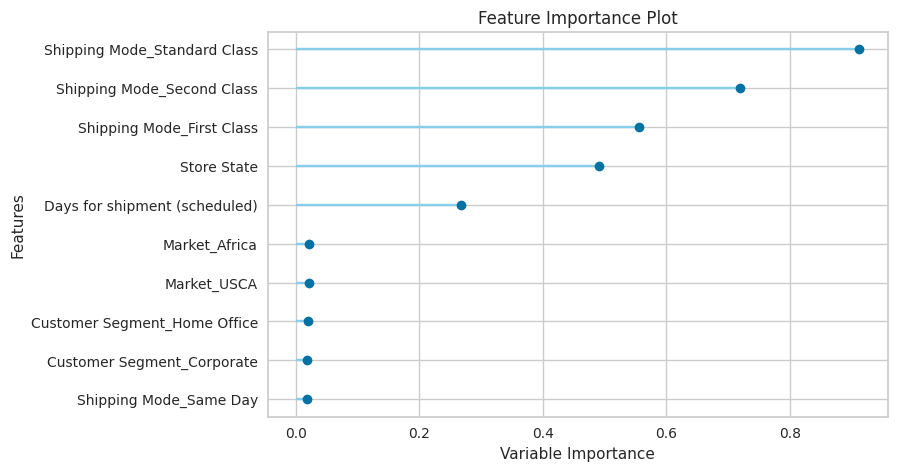

In [51]:
plot_model(top_model, plot='feature')

In [52]:
# Unseen Data Prediction
df_predicted = predict_model(estimator=top_model, data=df_test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Linear Discriminant Analysis,0.5514,0.6990,0,0,0,0.3185,0.3698


In [53]:
# show the confusion matrix
confusion_matrix(
    y_true=df_predicted['Delivery Status'],
    y_pred=df_predicted['prediction_label'])

array([[4467,   94,    0,    0],
       [4432, 5871,    0,  538],
       [ 469,  317,    0,   45],
       [2196,  758,    0,  539]])

In [54]:
# show the classification report
print(classification_report(
    y_true=df_predicted['Delivery Status'],
    y_pred=df_predicted['prediction_label']))

                   precision    recall  f1-score   support

 Advance shipping       0.39      0.98      0.55      4561
    Late delivery       0.83      0.54      0.66     10841
Shipping canceled       0.00      0.00      0.00       831
 Shipping on time       0.48      0.15      0.23      3493

         accuracy                           0.55     19726
        macro avg       0.43      0.42      0.36     19726
     weighted avg       0.63      0.55      0.53     19726

